# Environment setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Gridsearch with a dedicated validation set (without CV)
! pip install hypopt &> /dev/null

# Latex for output
! apt install texlive-latex-recommended -qq &> /dev/null
! apt install texlive-latex-extra -qq &> /dev/null
! apt install dvipng -qq &> /dev/null
! apt install cm-super -qq &> /dev/null
! python -m spacy download en_core_web_md &> /dev/null

# Load repository

!git clone https://github.com/dafrie/fin-disclosures-nlp.git &> /dev/null
%cd /content/fin-disclosures-nlp

/content/fin-disclosures-nlp


In [3]:
import os
import sys

import numpy as np
import pandas as pd
import sklearn
import logging

# sys.path.append('..')
sys.path.append('.')

%load_ext autoreload
%autoreload 2

from data import constants
# This module depends on spacy's language models, need to restart the runtime to reload once downloaded.
try:
  from data import dataframe_preparation
except OSError:
  print("Crashing")
  exit()
from data import evaluation

logging.basicConfig(level=logging.INFO)

# Config

## Task setup

In [4]:
class Params:
  TASK = "binary" #@param ["binary", "multi-label"]
  CATEGORY_LEVEL = "cro" #@param ["cro", "cro_sub_type"]
  SCENARIO = "realistic" #@param [ "optimistic", "realistic", "discriminatory"]

  # Evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
  AVERAGING_STRATEGY = "macro" #@param ["micro",  "macro", "weighted"]
  SCORING_METRIC = "average_precision" #@param ["average_precision", "roc_auc"]

  RESULTS_FILE_NAME = f"{CATEGORY_LEVEL}_{TASK}_results.csv"

  # To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
  SEED_VALUE = 4200

params = Params()

## Model setup

In [5]:
# See list here: https://huggingface.co/models
params.MODEL_TYPE  = 'baseline' #@param ["baseline"]
params.MODEL_NAME = 'svm' #@param ["svm"]
params.model_name = params.MODEL_NAME

## Data setup

In [6]:
params.scenario = params.SCENARIO
params.DIR = "/content/drive/MyDrive/fin-disclosures-nlp"
params.DATA_DIR = os.path.join(params.DIR, "data", "labels")
params.MODELS_DIR = os.path.join(params.DIR, "models", params.MODEL_TYPE)
params.RESULTS_DIR = os.path.join(params.DIR, 'results')
params.RESULTS_FILE_PATH = os.path.join(params.RESULTS_DIR, params.RESULTS_FILE_NAME)

## Evaluation setup

In [7]:
# Load/Initialize results file
results = evaluation.Results(params.RESULTS_FILE_PATH, vars(params))

## Data loading

In [8]:
if params.CATEGORY_LEVEL == "cro":
  CATEGORY_CODES = ["PR", "TR"]
elif params.CATEGORY_LEVEL == "cro_sub_type": 
  CATEGORY_CODES = ["ACUTE", "CHRON", "POLICY", "MARKET", "REPUT"]

train_df = pd.read_csv(os.path.join(params.DATA_DIR, f"train_explicit.csv"))
train_df = train_df.sample(frac=1, random_state=params.SEED_VALUE)

train_df["PR"] = train_df[["ACUTE", "CHRON"]].any(axis=1)
train_df["TR"] = train_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)
train_df["IS_CLIMATE_RISK"] = train_df[CATEGORY_CODES].any(axis=1)

task_labels = CATEGORY_CODES
if params.TASK == "binary":
  task_labels = ["IS_CLIMATE_RISK"]

train_text = train_df.text
train_labels = train_df[task_labels].astype("bool")

In [9]:
valid_df = pd.read_csv(os.path.join(params.DATA_DIR, f"valid_{params.SCENARIO}.csv"))
valid_df = valid_df.sample(frac=1, random_state=params.SEED_VALUE)

test_df = pd.read_csv(os.path.join(params.DATA_DIR, f"test_{params.SCENARIO}.csv"))
test_df = test_df.sample(frac=1, random_state=params.SEED_VALUE)

valid_df["PR"] = valid_df[["ACUTE", "CHRON"]].any(axis=1)
valid_df["TR"] = valid_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)
valid_df["IS_CLIMATE_RISK"] = valid_df[CATEGORY_CODES].any(axis=1)

test_df["PR"] = test_df[["ACUTE", "CHRON"]].any(axis=1)
test_df["TR"] = test_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)
test_df["IS_CLIMATE_RISK"] = test_df[CATEGORY_CODES].any(axis=1)

valid_df["text"] = valid_df.text.replace(np.nan, '')
valid_text = valid_df.text
valid_labels = valid_df[task_labels].astype("bool")

test_df["text"] = test_df.text.replace(np.nan, '')
test_text = test_df.text
test_labels = test_df[task_labels].astype("bool")

# Model initialization and training

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score

# Custom scorer so we can pass in the averaging strategy
avg_scorer = make_scorer(average_precision_score if params.SCORING_METRIC == 'average_precision' else roc_auc_score, average=params.AVERAGING_STRATEGY)

svc_clf = SVC(probability=True, random_state=params.SEED_VALUE, class_weight="balanced") # Balanced: n_samples / (n_classes * np.bincount(y)). Since we are doing OneVsRest, this should be giving correct weights!
# Wrap with OvR in case of multi-label
multi_label_clf = OneVsRestClassifier(svc_clf)

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(strip_accents = 'ascii')),
    ('tfidf', TfidfTransformer()),
    ('classifier', multi_label_clf if params.TASK == "multi-label" else svc_clf),
     ])

# Parameters to tune automatically with a grid search
# Note: The nested estimator is accessible via the __estimator identifier
param_svm = [
  {
      'bow__tokenizer': [dataframe_preparation.spacy_tokenizer],
      'bow__stop_words': ['english'],
      'bow__ngram_range': [(1, 1), (1, 2)],
      #'bow__ngram_range': [(1, 1)],
      'bow__max_features': [50, 500],
      #'bow__max_features': [500],
      'tfidf__use_idf': [True], 
      'classifier__estimator__C' if params.TASK == "multi-label" else 'classifier__C': [1, 10, 100], 
      #'classifier__estimator__C' if params.TASK == "multi-label" else 'classifier__C': [100], 
      'classifier__estimator__kernel' if params.TASK == "multi-label" else 'classifier__kernel': ['linear', 'rbf']},
      #'classifier__estimator__kernel' if params.TASK == "multi-label" else 'classifier__kernel': ['linear']},
      
]

grid_clf = GridSearchCV(
    pipeline_svm,
    param_grid=param_svm,
    refit=True,
    n_jobs=-1, 
    scoring=avg_scorer,
    cv=5,
    verbose=10
)

# Grid search fitting
grid_clf.fit(train_text, train_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepr

In [11]:
cv_results = pd.DataFrame(grid_clf.cv_results_)

print(f"Best {params.SCORING_METRIC} score: {grid_clf.best_score_}")
print(f"Best params: \n{grid_clf.best_params_}")

Best average_precision score: 0.780104564811882
Best params: 
{'bow__max_features': 500, 'bow__ngram_range': (1, 2), 'bow__stop_words': 'english', 'bow__tokenizer': <function spacy_tokenizer at 0x7f5fe0545950>, 'classifier__C': 10, 'classifier__kernel': 'rbf', 'tfidf__use_idf': True}


In [12]:
valid_preds_prob = grid_clf.predict_proba(valid_text)

In [22]:
if params.TASK == "binary":
  valid_preds_prob = valid_preds_prob[:,1]

In [32]:
df_t = pd.DataFrame(data={ "IS_CLIMATE_RISK": valid_preds_prob })

In [38]:
np.reshape(valid_preds_prob, (-1, 1))

array([[0.03734692],
       [0.02257259],
       [0.01172689],
       ...,
       [0.01079065],
       [0.01332989],
       [0.37508374]])

In [39]:
test = np.reshape(valid_preds_prob, (-1, 1))

/content/fin-disclosures-nlp/data/evaluation.py:127: RuntimeWarning: invalid value encountered in true_divide
  ) / (precision[idx] + recall[idx])
/content/fin-disclosures-nlp/data/evaluation.py:130: RuntimeWarning: invalid value encountered in true_divide
  1 + beta*beta) * ((precision[idx] * recall[idx]) / ((beta*beta*precision[idx]) + recall[idx]))


,ROC AuC,PR AuC
0,0.948377,0.198337


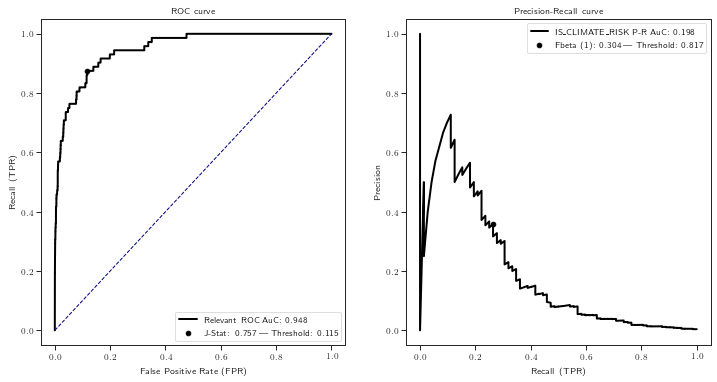

In [40]:
valid_threshold_moving_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_threshold.pdf")
valid_eval_scores, best_roc_threshold, best_pr_threshold = evaluation.threshold_moving_report(valid_labels, test, export_path=valid_threshold_moving_report, beta=1)
results.log_experiment(valid_eval_scores, prefix="valid")
results.log_experiment({ "best_pr_threshold": best_pr_threshold.values(), "best_roc_threshold": best_roc_threshold.values()}, prefix="valid")
valid_eval_scores

## Validation results

In [60]:
import json
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report, multilabel_confusion_matrix


def test_evaluation_report(labels, preds_probs, thresholds, averaging="macro", export_path=None):

    is_binary = True
    np.shape(labels)[1]
    #except IndexError:
    #    is_binary = True
    #    # preds_probs = preds_probs[:, 1]
    #    labels = labels.to_frame(name="Relevant")

    print(is_binary)
    # 1) Calculate AuC evaluation metrics
    roc_auc = roc_auc_score(labels, preds_probs, average=averaging)
    pr_auc = average_precision_score(labels, preds_probs, average=averaging)

    # Set labels based on provided threshold values
    preds_bool = preds_probs > np.array([i for i in thresholds])

    # Print the classification evaluation metrics
    print(f"Using threshold values {thresholds}")
    print(classification_report(labels, preds_bool, target_names=labels.columns if not is_binary else None))
    cls_report = classification_report(
        labels, preds_bool, labels=[1] if is_binary else None, target_names=labels.columns if not is_binary else None, output_dict=True)

    # Plot confusion matrix
    mcm = multilabel_confusion_matrix(labels, preds_bool)
    if is_binary:
        mcm = mcm[1:]
    # The cm output of scikit-learn is flipped...
    flipped_mcm = []
    for i in mcm:
        flipped_mcm.append(np.flip(np.rot90(np.fliplr(i))).tolist())

    scores = pd.DataFrame(data={"ROC AuC": [roc_auc], "PR AuC": [
                          pr_auc], "F1": [cls_report["macro avg"]["f1-score"]], "Report": [json.dumps(cls_report)], "CMS": [json.dumps(flipped_mcm)]})

    return scores

valid_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_evaluation.pdf")
valid_eval_scores = test_evaluation_report(valid_labels, valid_preds_prob, best_pr_threshold.values(), export_path=valid_evaluation_report)
results.log_experiment(valid_eval_scores, prefix="valid")
valid_eval_scores

True
Using threshold values dict_values([0.8166370466674366])
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     39007
        True       0.35      0.25      0.29        72

    accuracy                           1.00     39079
   macro avg       0.67      0.62      0.64     39079
weighted avg       1.00      1.00      1.00     39079



,ROC AuC,PR AuC,F1,Report,CMS
0,0.948377,0.198337,0.290323,"{""1"": {""precision"": 0.34615384615384615, ""reca...","[[[18, 34], [54, 38973]]]"


In [51]:
preds_probs = valid_preds_prob[:, 1]

IndexError: ignored